Khai báo thư viện

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(20)
pd.set_option('display.max_rows', None)

Khai báo các hàm sử dụng

In [2]:
class Gaussion_dist(BaseEstimator, TransformerMixin):
    def __init__(self, feature: str, isInt=True) -> None:
        self.feature = feature
        self.isInt = isInt
    def fit(self, X: pd.DataFrame, y=None):
        self.uppper_boundary = X[self.feature].mean() + 3*X[self.feature].std()
        self.lower_boundary = X[self.feature].mean() - 3*X[self.feature].std()
        if self.isInt:
            self.uppper_boundary = int(self.uppper_boundary)
            self.lower_boundary = int(self.lower_boundary)
        return self
    def transform(self, X: pd.DataFrame):
        X_copy = X.copy()
        X_copy.loc[X_copy[self.feature]>=self.uppper_boundary, self.feature] = self.uppper_boundary
        X_copy.loc[X_copy[self.feature]<=self.lower_boundary, self.feature] = self.lower_boundary
        return X_copy

In [3]:
class Skewed_dist(BaseEstimator, TransformerMixin):
    def __init__(self, feature: str, isInt=True) -> None:
        self.feature = feature
        self.isInt = isInt
    def fit(self, X: pd.DataFrame, y=None):
        IQR = X[self.feature].quantile(0.75) - X[self.feature].quantile(0.25)
        self.uppper_bridge = X[self.feature].quantile(0.75)+(IQR*1.5)
        self.lower_bridge = X[self.feature].quantile(0.25)-(IQR*1.5)
        if self.isInt:
            self.uppper_bridge = int(self.uppper_bridge)
            self.lower_bridge = int(self.lower_bridge)
        return self
    def transform(self, X: pd.DataFrame):
        X_copy = X.copy()
        X_copy.loc[X_copy[self.feature]>=self.uppper_bridge, self.feature] = self.uppper_bridge
        X_copy.loc[X_copy[self.feature]<=self.lower_bridge, self.feature] = self.lower_bridge
        return X_copy

In [4]:
def r2_score_predict(X: pd.DataFrame, y: pd.DataFrame, pipe: Pipeline):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)
    pipe.fit(X_train, y_train)
    r2_train = r2_score(y_train, pipe.predict(X_train))
    r2_test = r2_score(y_test, pipe.predict(X_test))
    return r2_train, r2_test

In [5]:
def getPipeline(year_outlier=None,number_of_km_outlier=None, transformer=None, function=None):
    steps = []
    if year_outlier != None:
        steps.append(('year_outlier', year_outlier))
    if number_of_km_outlier != None:
        steps.append(('number_of_km_outlier', number_of_km_outlier))
    if transformer != None:
        steps.append(('transformer', transformer))
    steps.append(('PCA', PCA(n_components=30)))
    steps.append(('LinearRegression',function))
    return Pipeline(steps=steps)

In [6]:
def getData(data):
    df_new = pd.get_dummies(data, columns= ['Loại xe', 'Dung tích xe', 'Hãng xe', 'Dòng xe'])
    df_new = df_new.drop(['Tình trạng', 'Xuất xứ', 'Chính sách bảo hành'], axis=1)
    df_new = df_new[(df_new['Giá'] < 50000000) & (df_new['Giá'] > 1000000)]
    X = df_new.drop("Giá", axis=1)
    y = df_new["Giá"]
    return X, y

# Mô hình hóa dữ liệu trên Small Dataset

In [7]:
data=pd.read_csv('clean_data/smalldataset.csv')
data.head()

,Hãng xe,Dòng xe,Năm đăng ký,Số Km đã đi,Tình trạng,Loại xe,Dung tích xe,Xuất xứ,Chính sách bảo hành,Giá
0,Yamaha,Nozza,2014,16000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,12800000
1,Honda,Air Blade,2013,900000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,20500000
2,Honda,Vision,2019,18236,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,29600000
3,Honda,@,2007,123456,Đã sử dụng,Xe số,100 - 175 cc,Nhật Bản,Bảo hành hãng,8000000
4,Yamaha,Exciter,2013,2499,Đã sử dụng,Tay côn/Moto,100 - 175 cc,Đang cập nhật,Bảo hành hãng,10800000


In [8]:
X, y = getData(data)

In [9]:
function_list = [LinearRegression(), GradientBoostingRegressor()]
r2_train_list_small = []
r2_test_list_small = []
rmse_train_list_small = []
rmse_test_list_small = []
for function in function_list:
    r2_train, r2_test = r2_score_predict(X, y, getPipeline(None, Gaussion_dist('Năm đăng ký', isInt=True), StandardScaler() ,function))
    r2_train_list_small.append(r2_train)
    r2_test_list_small.append(r2_test)
df = pd.DataFrame({'Model': ['Linear Regression', 'Gradient Boosting'], 
                'R2 score on test set (small)': r2_test_list_small,
                'R2 score on train set (small)': r2_train_list_small})
print(df)

               Model  R2 score on test set (small)  \
0  Linear Regression                      0.318612   
1  Gradient Boosting                      0.582220   

   R2 score on train set (small)  
0                       0.363914  
1                       0.668233  


In [10]:
# mean_squared_error
rmse_train_list_small = []
rmse_test_list_small = []
mae_train_list_small = []
mae_test_list_small = []
for function in function_list:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)
    pipe = getPipeline(None, Gaussion_dist('Năm đăng ký', isInt=True), StandardScaler() ,function)
    pipe.fit(X_train, y_train)
    rmse_train = mean_squared_error(y_train, pipe.predict(X_train), squared=False)
    rmse_test = mean_squared_error(y_test, pipe.predict(X_test), squared=False)   
    rmse_train_list_small.append(rmse_train)
    rmse_test_list_small.append(rmse_test)
    mae_train = mean_absolute_error(y_train, pipe.predict(X_train))
    mae_test = mean_absolute_error(y_test, pipe.predict(X_test))
    mae_train_list_small.append(mae_train)
    mae_test_list_small.append(mae_test)
metric = pd.DataFrame({'Model': ['Linear Regression', 'Gradient Boosting'],
                'RMSE on test set (small)': rmse_test_list_small,
                'RMSE on train set (small)': rmse_train_list_small,
                'MAE on test set (small)': mae_test_list_small,
                'MAE on train set (small)': mae_train_list_small})
print(metric)

               Model  RMSE on test set (small)  RMSE on train set (small)  \
0  Linear Regression              9.226840e+06               9.654875e+06   
1  Gradient Boosting              7.284847e+06               6.630051e+06   

   MAE on test set (small)  MAE on train set (small)  
0             7.126190e+06              7.456756e+06  
1             5.137299e+06              4.652316e+06  


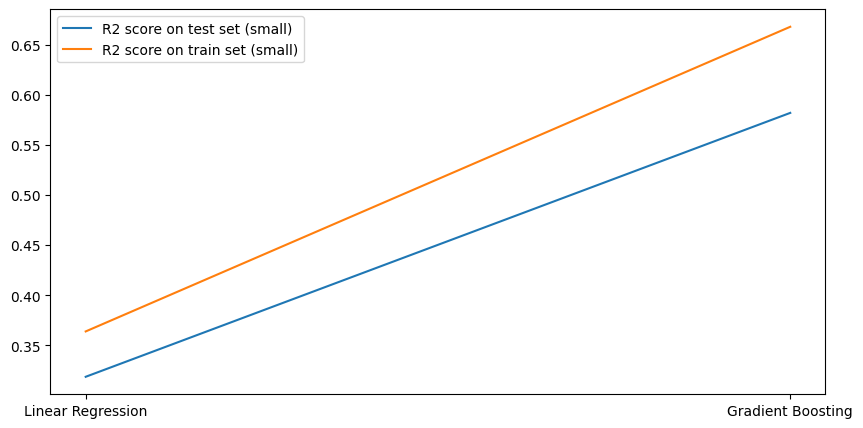

In [11]:
# vẽ biểu đồ so sánh R2 score trên tập train và test của 2 model
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(df['Model'], df['R2 score on test set (small)'], label='R2 score on test set (small)')
plt.plot(df['Model'], df['R2 score on train set (small)'], label='R2 score on train set (small)')
plt.legend()
plt.show()


# Mô hình hóa dữ liệu trên Big Dataset

In [12]:
data=pd.read_csv('clean_data/bigdataset.csv')
data.head()

,Hãng xe,Dòng xe,Năm đăng ký,Số Km đã đi,Tình trạng,Loại xe,Dung tích xe,Xuất xứ,Chính sách bảo hành,Giá
0,Honda,Wave,1996,20000,Đã sử dụng,Xe số,100 - 175 cc,Đang cập nhật,Bảo hành hãng,1500000.0
1,Piaggio,Liberty,2014,3000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,9500000.0
2,Honda,Cub,1992,70000,Đã sử dụng,Xe số,50 - 100 cc,Đang cập nhật,Bảo hành hãng,12000000.0
3,Yamaha,Exciter,2014,29000,Đã sử dụng,Xe số,100 - 175 cc,Đang cập nhật,Bảo hành hãng,9300000.0
4,Yamaha,Nouvo,2011,55555,Đã sử dụng,Tay ga,50 - 100 cc,Đang cập nhật,Bảo hành hãng,6200000.0


In [13]:
X, y = getData(data)

In [14]:
function_list = [LinearRegression(), GradientBoostingRegressor()]
r2_train_list = []
r2_test_list = []
for function in function_list:
    r2_train, r2_test = r2_score_predict(X, y, getPipeline(Skewed_dist('Năm đăng ký', isInt=False), Skewed_dist('Số Km đã đi', isInt=False),None,function))
    r2_train_list.append(r2_train)
    r2_test_list.append(r2_test)
df = pd.DataFrame({'Model': ['Linear Regression', 'Gradient Boosting'], 
                'R2 score on test set (big)': r2_test_list,
                'R2 score on train set (big)': r2_train_list})
print(df)

               Model  R2 score on test set (big)  R2 score on train set (big)
0  Linear Regression                    0.394071                     0.424317
1  Gradient Boosting                    0.613410                     0.681325


In [15]:
# mean_squared_error
rmse_train_list = []
rmse_test_list = []
mae_train_list = []
mae_test_list = []

for function in function_list:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)
    pipe = getPipeline(Skewed_dist('Năm đăng ký', isInt=False), Skewed_dist('Số Km đã đi', isInt=False),None,function)
    pipe.fit(X_train, y_train)
    rmse_train = mean_squared_error(y_train, pipe.predict(X_train), squared=False)
    rmse_test = mean_squared_error(y_test, pipe.predict(X_test), squared=False)
    rmse_train_list.append(rmse_train)
    rmse_test_list.append(rmse_test)
    mae_train = mean_absolute_error(y_train, pipe.predict(X_train))
    mae_test = mean_absolute_error(y_test, pipe.predict(X_test))
    mae_train_list.append(mae_train)
    mae_test_list.append(mae_test)
metric = pd.DataFrame({'Model': ['Linear Regression', 'Gradient Boosting'],
                'RMSE on test set (big)': rmse_test_list,
                'RMSE on train set (big)': rmse_train_list,
                'MAE on test set (big)': mae_test_list,
                'MAE on train set (big)': mae_train_list})
print(metric)

               Model  RMSE on test set (big)  RMSE on train set (big)  \
0  Linear Regression            9.102768e+06             8.816044e+06   
1  Gradient Boosting            7.353168e+06             6.613959e+06   

   MAE on test set (big)  MAE on train set (big)  
0           6.882313e+06            6.665372e+06  
1           5.292688e+06            4.812550e+06  


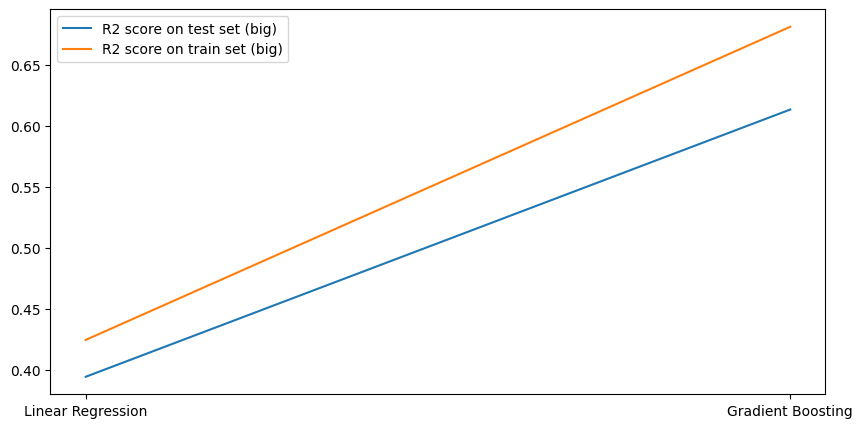

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(df['Model'], df['R2 score on test set (big)'], label='R2 score on test set (big)')
plt.plot(df['Model'], df['R2 score on train set (big)'], label='R2 score on train set (big)')
plt.legend()
plt.show()